In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
from scipy.linalg import eigh
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.plotting import plot_decision_regions


df = pd.read_csv('/home/aaronpham5504/personalFolder/MSA/Project/MSA-Vstatis/Data/Stars.csv', encoding='ascii')
print(df.head())

   Temperature         L       R    A_M Color Spectral_Class  Type
0         3068  0.002400  0.1700  16.12   Red              M     0
1         3042  0.000500  0.1542  16.60   Red              M     0
2         2600  0.000300  0.1020  18.70   Red              M     0
3         2800  0.000200  0.1600  16.65   Red              M     0
4         1939  0.000138  0.1030  20.06   Red              M     0


## Data Preprocessing

In [3]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]
cat_features_list = X.select_dtypes(include=['object']).columns
X[cat_features_list] = X[cat_features_list].apply(LabelEncoder().fit_transform)

X, y = X.values, LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (180, 6)
X_test shape: (60, 6)
y_train shape: (180,)
y_test shape: (60,)


## Within-class Variance

In [4]:
def calculate_within_class_scatter(X, y, num_classes):
    """
    Compute the within-class scatter matrix (Sw).

    Args:
        X (numpy.ndarray): Input data matrix (n_samples x n_features).
        y (numpy.ndarray): Class labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Within-class scatter matrix (Sw).
    """
    n_features = X.shape[1]
    Sw = np.zeros((n_features, n_features))  # Initialize Sw

    for cls in range(num_classes):  # Iterate over each class
        X_cls = X[y == cls]  # Samples belonging to the current class
        if len(X_cls) > 0:
            mean_cls = np.mean(X_cls, axis=0)  # Mean vector of the class
            diff = X_cls - mean_cls  # Center the samples
            Sw += diff.T @ diff  # Accumulate scatter matrix

    return Sw

## Between Class Variance

In [5]:
def calculate_between_class_scatter(X, y, num_classes):
    """
    Compute the between-class scatter matrix (Sb).

    Args:
        X (numpy.ndarray): Input data matrix (n_samples x n_features).
        y (numpy.ndarray): Class labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Between-class scatter matrix (Sb).
    """
    n_features = X.shape[1]
    overall_mean = np.mean(X, axis=0)  # Overall mean vector
    Sb = np.zeros((n_features, n_features))  # Initialize Sb

    for cls in range(num_classes):  # Iterate over each class
        X_cls = X[y == cls]  # Samples belonging to the current class
        n_cls = len(X_cls)  # Number of samples in the class
        if n_cls > 0:
            mean_cls = np.mean(X_cls, axis=0)  # Mean vector of the class
            diff = (mean_cls - overall_mean).reshape(-1, 1)  # (mean_cls - overall_mean)
            Sb += n_cls * (diff @ diff.T)  # Accumulate scatter matrix

    return Sb

## LDA Objective Function

In [6]:
def lda_objective_function(W, SW, SB):
    """
    Tính giá trị của hàm mục tiêu LDA cho ma trận chiếu W.

    Args:
        W (numpy.ndarray): Ma trận chiếu (d x m).
        SW (numpy.ndarray): Ma trận tán xạ nội tại (d x d).
        SB (numpy.ndarray): Ma trận tán xạ ngoại tại (d x d).

    Returns:
        float: Giá trị của hàm mục tiêu.
    """
    WT_SW_W = np.dot(W.T, np.dot(SW, W))
    WT_SB_W = np.dot(W.T, np.dot(SB, W))

    # Kiểm tra xem WT_SW_W có khả nghịch không
    try:
        WT_SW_W_inv = np.linalg.inv(WT_SW_W)
    except np.linalg.LinAlgError:
        print("Ma trận WT_SW_W là suy biến, không thể tính nghịch đảo.")
        return -np.inf  # Trả về giá trị âm vô cùng để biểu thị trường hợp không hợp lệ

    objective_value = np.trace(np.dot(WT_SW_W_inv, WT_SB_W))
    return objective_value

## Optimized Problem

In [7]:
def solve_lda(X, y, num_classes, num_components):
    """
    Solve the LDA optimization problem to find the projection matrix W.

    Args:
        X (numpy.ndarray): Input data matrix (n_samples x n_features).
        y (numpy.ndarray): Class labels.
        num_classes (int): Number of classes.
        num_components (int): Number of components to retain.

    Returns:
        numpy.ndarray: Projection matrix W (n_features x num_components).
    """
    # Compute scatter matrices
    Sw = calculate_within_class_scatter(X, y, num_classes)
    Sb = calculate_between_class_scatter(X, y, num_classes)

    # Solve the generalized eigenvalue problem for Sb and Sw
    try:
        eigenvalues, eigenvectors = eigh(Sb, Sw)  # Use scipy.linalg.eigh for stability
    except np.linalg.LinAlgError as e:
        print(f"Error solving eigenvalue problem: {e}")
        return None

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select the top num_components eigenvectors
    W = eigenvectors[:, :num_components]
    return W

## Classification

In [8]:
def predict_lda(X, W, X_train, y_train):
    """
    Predict class labels for new data points using LDA.

    Args:
        X (numpy.ndarray): Data to classify (n_samples x n_features).
        W (numpy.ndarray): Projection matrix (n_features x n_components).
        X_train (numpy.ndarray): Training data (n_samples x n_features).
        y_train (numpy.ndarray): Training labels (n_samples).

    Returns:
        numpy.ndarray: Predicted class labels (n_samples).
    """
    # Project the training data into the LDA space
    X_train_projected = X_train @ W

    # Compute class centroids in the LDA space
    classes = np.unique(y_train)
    centroids = np.array([X_train_projected[y_train == cls].mean(axis=0) for cls in classes])

    # Project the new data into the LDA space
    X_projected = X @ W

    # Assign each point to the nearest centroid
    distances = np.linalg.norm(X_projected[:, np.newaxis] - centroids, axis=2)
    predictions = classes[np.argmin(distances, axis=1)]

    return predictions

In [9]:
class CustomLDAClassifier:
    def __init__(self, W, X_train, y_train):
        self.W = W
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X):
        return predict_lda(X, self.W, self.X_train, self.y_train)

**Run on Stars Dataset** 

In [20]:
# Number of classes and components
num_classes = len(np.unique(y_train))
num_components = num_classes - 1  # Number of components to retain

# Solve LDA
W = solve_lda(X_train, y_train, num_classes, num_components)

# Project the training data
X_train_projected = X_train @ W

print(X_train.shape)
print(X_train_projected.shape)

# Predict on test data
lda_pred_res = predict_lda(X_test, W, X_train, y_train)

# Evaluate accuracy
lda_accuracy = accuracy_score(y_test, lda_pred_res)

print(f"LDA Accuracy: {lda_accuracy:.4f}")
print(f"Predictions: {lda_pred_res}")
print("Transformed Features", X_train_projected[:5].T, sep='\n')

(180, 6)
(180, 5)
LDA Accuracy: 1.0000
Predictions: [4 1 3 1 4 4 3 4 3 1 1 2 2 3 5 1 0 5 4 0 4 5 2 0 0 2 1 3 1 4 5 4 2 0 2 5 2
 5 0 3 3 4 3 1 4 1 4 0 5 5 0 3 5 1 3 3 5 3 5 4]
Transformed Features
[[ 0.48837327 -0.0638919   0.16134368 -0.82217395  0.56801609]
 [ 0.27909366 -0.08185509  0.09040409  0.65258814  0.28979529]
 [ 0.16581344  0.08146144 -0.05473263 -0.18429529 -0.07182942]
 [-0.20765507 -0.23509196 -0.32620106 -0.08827843 -0.03504236]
 [ 0.26068818  0.38740425  0.32905055  0.39246032  0.21719541]]


**Predictions visualization**

In [11]:
# Scatter plot of the data before applying LDA
def plot_raw_data(X, y, feature_indexes, class_labels=None):
    """
    Plot the raw data using the selected features to visualize class overlap.

    Args:
        X (numpy.ndarray): Feature matrix.
        y (numpy.ndarray): Target labels.
        feature_indexes (list): List of feature indexes to plot (2D plot).
        class_labels (list): Optional list of class labels for the legend.
    """
    plt.figure(figsize=(8, 6))
    
    # Extract the selected features
    X_selected = X[:, feature_indexes]
    feature_x, feature_y = feature_indexes
    
    # Scatter plot for each class
    classes = np.unique(y)
    for cls in classes:
        plt.scatter(
            X_selected[y == cls, 0],  # Feature 1
            X_selected[y == cls, 1],  # Feature 2
            label=f"Class {cls}" if class_labels is None else class_labels[cls],
            alpha=0.7
        )
    
    # Add labels and title
    plt.xlabel(f"Feature {feature_x}")
    plt.ylabel(f"Feature {feature_y}")
    plt.title("Raw Data Visualization (Before LDA)")
    plt.legend()
    plt.grid(True)
    plt.show()

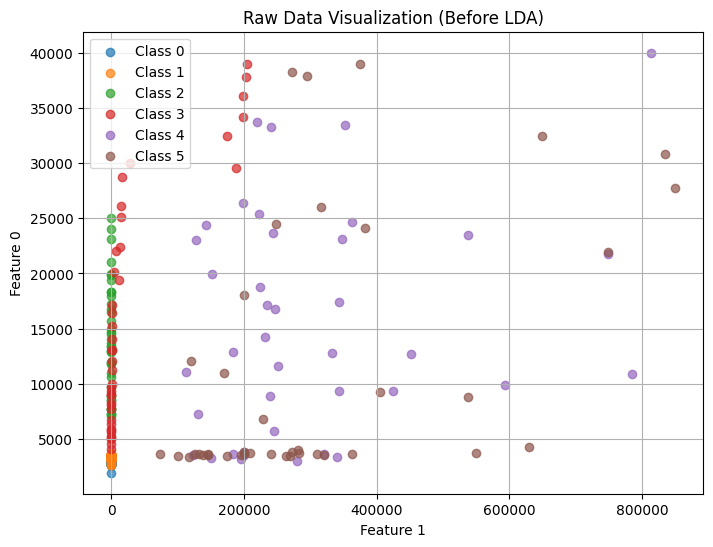

In [12]:
feature_indexes = [1, 0]  # Example feature indexes to plot
plot_raw_data(X,y, feature_indexes)

Number of classes: 6
Number of components: 5


/home/aaronpham5504/personalFolder/MSA/Project/MSA-Vstatis/venv/lib/python3.12/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


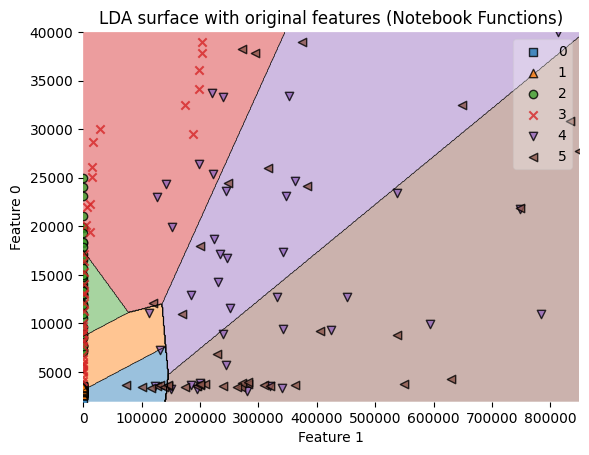

In [ ]:
# Step 1: Compute the projection matrix
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")
num_components = num_classes - 1
print(f"Number of components: {num_components}")
W = solve_lda(X_train[:, feature_indexes], y_train, num_classes, num_components)

# Step 2: Create a custom classifier using the projection matrix
custom_clf = CustomLDAClassifier(W, X_train[:, feature_indexes], y_train)

# Step 3: Visualize the decision regions
plt.title('LDA surface with original features')
plot_decision_regions(X=X[:, feature_indexes], y=y, clf=custom_clf)
plt.xlabel(f"Feature {feature_indexes[0]}")
plt.ylabel(f"Feature {feature_indexes[1]}")
plt.show()

6
5
(6, 5)
(240, 5)


<Axes: title={'center': 'LDA surface with transformed features'}>

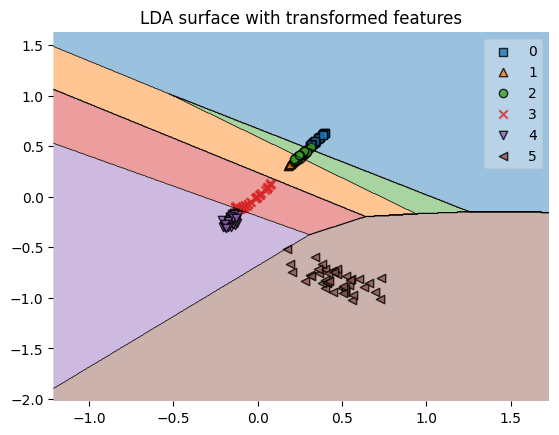

In [19]:
feature_indexes = [1, 0]
# sk_lda2 = LinearDiscriminantAnalysis(solver='eigen')
#X_lda = sk_lda2.fit(X, y).transform(X)
W = solve_lda(X, y, num_classes, num_components)

print(num_classes)
print(num_components)

X_lda = X @ W
print(W.shape)
print(X_lda.shape)

X_lda = X_lda[:, feature_indexes]

X_lda_train, X_lda_test, y_train, y_test = train_test_split(X_lda, y, random_state=0)

#sk_lda2.fit(X_lda_train, y_train)
W2 = solve_lda(X_lda_train, y_train, num_classes, num_components)
custom_clf = CustomLDAClassifier(W2, X_lda_train, y_train)

plt.title('LDA surface with transformed features')
plot_decision_regions(X=X_lda, y=y, clf=custom_clf)